# Decision Tree (Assignment 2)

## Student: Rodolfo Lerma

In this assignment, you will implement a Decision Tree algorithm from scratch and compare the results to existing sklearn algorithm. 

In [1]:
# import packages
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from matplotlib.legend_handler import HandlerLine2D
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.tree import DecisionTreeClassifier
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import GridSearchCV

# make this notebook's output stable across runs
np.random.seed(0)

**Before working on the questions for the assignment I will do a quick data exploration**

# Data Exploration

In [2]:
filename = 'data_banknote_authentication.csv'
df = pd.read_csv(filename, header=None)
df.head()

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


In [3]:
df.shape

(1372, 5)

We can see that the dataset is made out of 1372 rows and 5 columns (4 features and 1 target variable)

In [4]:
df.dtypes

0    float64
1    float64
2    float64
3    float64
4      int64
dtype: object

In [5]:
df.isnull().sum()

0    0
1    0
2    0
3    0
4    0
dtype: int64

No missing data in the dataset.

In [6]:
df.describe()

,0,1,2,3,4
count,1372.000000,1372.000000,1372.000000,1372.000000,1372.000000
mean,0.433735,1.922353,1.397627,-1.191657,0.444606
std,2.842763,5.869047,4.310030,2.101013,0.497103
min,-7.042100,-13.773100,-5.286100,-8.548200,0.000000
25%,-1.773000,-1.708200,-1.574975,-2.413450,0.000000
50%,0.496180,2.319650,0.616630,-0.586650,0.000000
75%,2.821475,6.814625,3.179250,0.394810,1.000000
max,6.824800,12.951600,17.927400,2.449500,1.000000


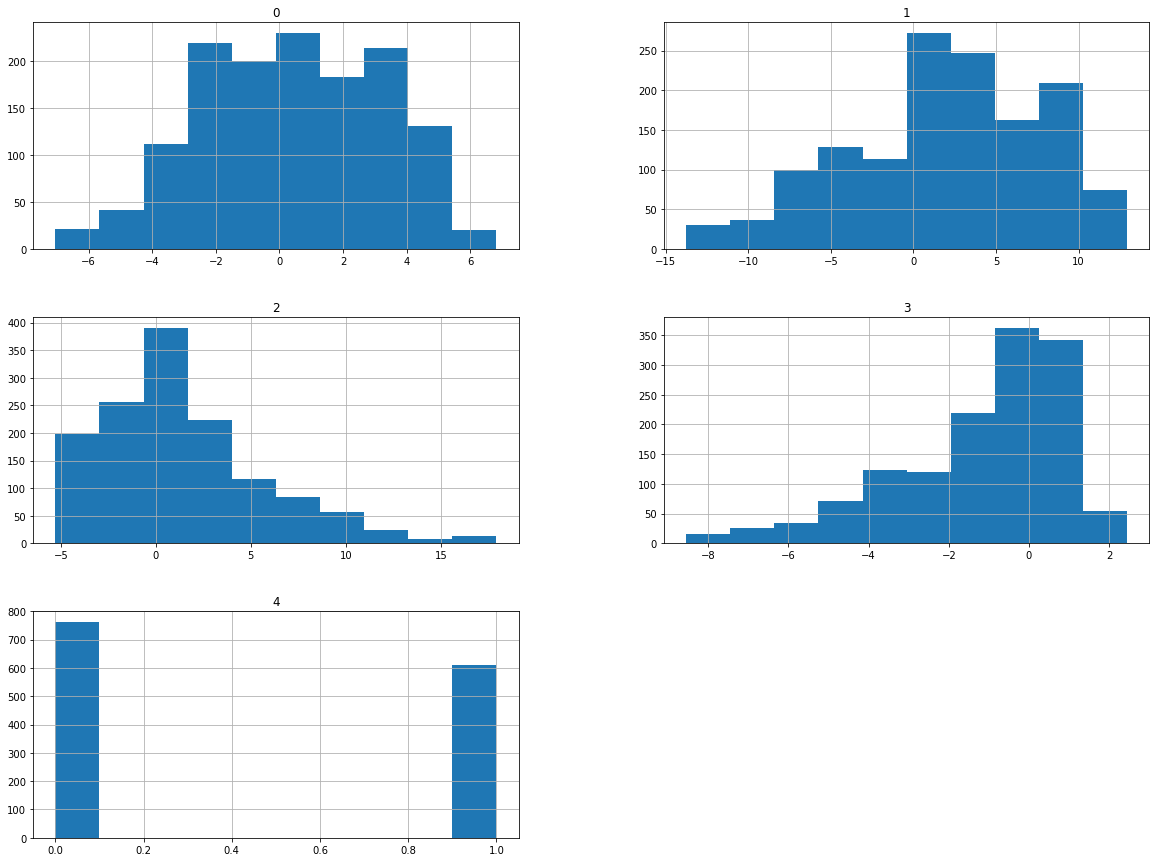

In [7]:
#Data distribution of the variables in the dataset
df.hist(figsize = (20,15))
plt.show()

### Target Variable Distribution

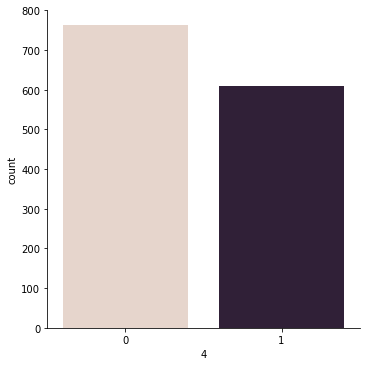

In [8]:
import seaborn as sns
sns.catplot(x=4, kind="count", palette="ch:.1", data=df)

In [9]:
df[4].value_counts()

0    762
1    610
Name: 4, dtype: int64

We can see that both target variables are more or less evenly distributed in our dataset. (No class imbalance present in our model)

### Correlation Analysis

<ipython-input-10-40f5d72b9255>:5: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.logical_not(np.tril(np.ones_like(corr, dtype=np.bool)))


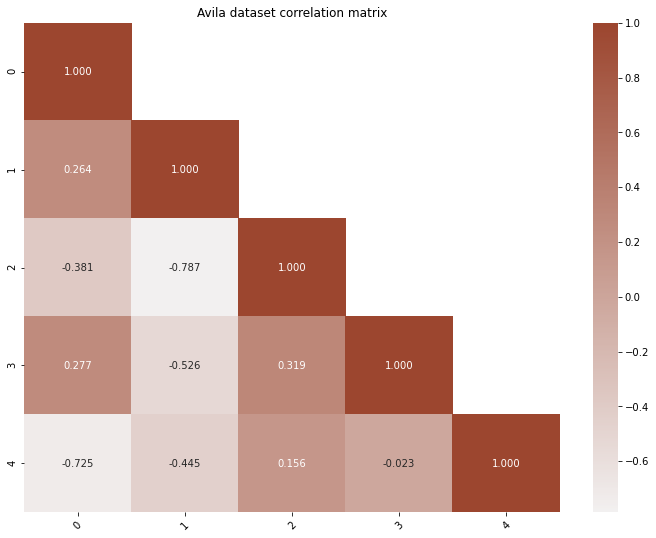

In [10]:
import seaborn as sns

corr = df.corr()
hm_fig, hm_ax = plt.subplots(figsize=(12,9))
mask = np.logical_not(np.tril(np.ones_like(corr, dtype=np.bool)))
sns.heatmap(
    corr,
    annot=True,
    mask=mask,
    fmt='.3f',
    ax=hm_ax,
    cmap=sns.light_palette('#9c462f', n_colors=300),
)
hm_ax.set_xticklabels(hm_ax.get_xticklabels(), rotation=45)
hm_ax.set_title('Avila dataset correlation matrix')
hm_ax.patch.set_alpha(0);

## Question 1.1: Implement the functions to calculate Gini Index.

In [11]:
# Calculate the Gini index for a split dataset
def gini_index(groups, classes):
    # TODO count all samples at split point
    n_instances = float(sum([len(group) for group in groups]))
    # TODO sum weighted Gini index for each group
    gini = 0.0
    for group in groups:
        size = float(len(group))
        # TODO avoid divide by zero
        if size == 0:
            continue
        score = 0.0
        # TODO score the group based on the score for each class
        for class_val in classes:
            p = [row[-1] for row in group].count(class_val) / size
            score += p * p
        # TODO weight the group score by its relative size
        gini += (1.0 - score) * (size / n_instances)
    return gini

## Question 2.1: Write a method that splits `the node` 

In [12]:
# Split a dataset based on an attribute and an attribute value
def test_split(index, value, dataset):
    left, right = list(), list()
    """
    TODO: This function loops over each row and checks if the row belongs to the right or left list.
    """ 
    for row in dataset:
        if row[index] < value:
            left.append(row)
        else:
            right.append(row)
    return left, right

## Question 2.2: Write a method that loops over the dataset, determine the groups of rows that belong to the right or left split, and calculates the gini_index

In [13]:
def get_split(dataset):
    "TODO Select the best split point for a dataset"
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            gini = gini_index(groups, class_values)
            if gini < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

## Question 2.3: Repeat question 2.2 using entropy

In [14]:
def get_split_entropy(dataset):
    "TODO Select the best split point for a dataset"
    class_values = list(set(row[-1] for row in dataset))
    b_index, b_value, b_score, b_groups = 999, 999, 999, None
    for index in range(len(dataset[0])-1):
        for row in dataset:
            groups = test_split(index, row[index], dataset)
            entropy = entropy(groups, class_values)
            if entropy < b_score:
                b_index, b_value, b_score, b_groups = index, row[index], gini, groups
    return {'index':b_index, 'value':b_value, 'groups':b_groups}

## Question 3.1: Write a method that takes in a group of rows and determines the class they belongs to. It should return the most common output value for a list of rows.

In [15]:
def to_terminal(group):
    "TODO determing the most commong output within each group"
    outcomes = [row[-1] for row in group]
    return max(set(outcomes), key=outcomes.count)

## Question 3.2: Write a method that recursively split the data.
The method takes in a node, max_depth, min_size, and depth. Initially, the method would be called by passing the rood node and depth of 1. Here are the steps to help you implement:

- First, we create two groups for the data split and delete any existing groups from the node. As rows are used, they are no longer needed.
- Second, check if rows should be in left or right group, and if so we create a terminal node using the records we have.
- Third, check if maximum depth is reached and if so we create a terminal node.
- Fourth, process left child, creating a terminal node if the group of rows is too small, otherwise creating and adding the left node in a depth first fashion until the bottom of the tree is reached on this branch.
- Fifth, process the right side in a similar manner as left side, as we rise back up the constructed tree to the root.

In [16]:
# Create child splits for a node or make terminal
def split(node, max_depth, min_size, depth):
    left, right = node['groups']
    del(node['groups'])
    # TODO check for a no split
    if not left or not right:
        node['left'] = node['right'] = to_terminal(left + right)
        return
    # TODO check for max depth
    if depth >= max_depth:
        node['left'], node['right'] = to_terminal(left), to_terminal(right)
        return
    # TODO process left child
    if len(left) <= min_size:
        node['left'] = to_terminal(left)
    else:
        node['left'] = get_split(left)
        split(node['left'], max_depth, min_size, depth+1)
    # TODO process right child
    if len(right) <= min_size:
        node['right'] = to_terminal(right)
    else:
        node['right'] = get_split(right)
        split(node['right'], max_depth, min_size, depth+1)

## Question 3.3: Write a method that builds the tree. The method creates an initial split to determine root node, and then calls the split method.

In [17]:
# Build a decision tree
def build_tree(train, max_depth, min_size):
    "TODO get the first split, and then split starting fromt the root"
    root = get_split(train)
    split(root, max_depth, min_size, 1)
    return root

## Question 3.4: Write a method that takes in a node and rows of data, and predicts the class associated with each row.

In [18]:
# Make a prediction with a decision tree
def predict(node, row):
    #TODO check if a row belongs to a node and recursively traverse the tree if the row doesn't.
    if row[node['index']] < node['value']:
        if isinstance(node['left'], dict):
            return predict(node['left'], row)
        else:
            return node['left']
    else:
        if isinstance(node['right'], dict):
            return predict(node['right'], row)
        else:
            return node['right']

## Question 4: Train a decision tree using the banknote_authentication data

In [19]:
from random import seed
from random import randrange
from csv import reader
from sklearn.metrics import accuracy_score

# Load a CSV file
def load_csv(filename):
    file = open(filename, "rt")
    lines = reader(file)
    dataset = list(lines)
    return dataset

# Convert string column to float
def str_column_to_float(dataset, column):
    for row in dataset:
        row[column] = float(row[column].strip())

In [20]:
filename = 'data_banknote_authentication.csv'
dataset = load_csv(filename)

In [21]:
# convert string attributes to integers
for i in range(len(dataset[0])):
    str_column_to_float(dataset, i)

train = dataset[1:np.int(len(dataset)*2/3)]
test = dataset[np.int(len(dataset)*2/3)+1:len(dataset)]

<ipython-input-21-d0bbec885f05>:5: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  train = dataset[1:np.int(len(dataset)*2/3)]
<ipython-input-21-d0bbec885f05>:6: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.

## Manual Decision Tree Model

In [22]:
#TODO Build a tree and evalute accuracy
max_depth = 4
min_size = 10
tree = build_tree(train, max_depth, min_size)

In [23]:
predictions = list()
for row in test:
    prediction = predict(tree, row)
    predictions.append(prediction)

In [24]:
print('Accuracy: %s' % accuracy_score([row[-1] for row in test], predictions))

Accuracy: 0.849015317286652


## [Bonus] Question 5: Train and evaluate an SKLEARN decision tree model, and compare the results to your model 

In [25]:
from sklearn.model_selection import train_test_split
target = df[4]
features = df.columns.tolist()
features.remove(4)
features_df = df[features]

### Splitting data

In [26]:
X_train, X_test, y_train, y_test = train_test_split(features_df, target, test_size=0.30, random_state=42)

### Decision Tree Hyperparameters

In [27]:
from sklearn.tree import DecisionTreeClassifier 
from sklearn.model_selection import RandomizedSearchCV

max_depth_options = [2,3,4,5,6,7,8,9,10]
min_sample_options = [2,3,4,5,6,7,8,9,10]
model_criterion = ['entropy', 'gini']
min_samples_leaf_options = [2,3,4,5,6,7,8,9,10]

dt_grid = {'criterion': model_criterion, 
           'max_depth': max_depth_options,
           'min_samples_split':min_sample_options,
           'min_samples_leaf':min_samples_leaf_options}

dt_base = DecisionTreeClassifier()

decision_trees_hyper = RandomizedSearchCV(estimator = dt_base, param_distributions = dt_grid, 
                               n_iter = 200, cv = 3, verbose = 2, random_state = 42, 
                               n_jobs = -1)

# Fit the random search model
decision_trees_hyper.fit(X_train, y_train)

hyper = decision_trees_hyper.best_params_
hyper

Fitting 3 folds for each of 200 candidates, totalling 600 fits


{'min_samples_split': 7,
 'min_samples_leaf': 3,
 'max_depth': 9,
 'criterion': 'entropy'}

### Final Model

In [28]:
dt = DecisionTreeClassifier(criterion=hyper['criterion'], max_depth = hyper['max_depth'], min_samples_split = hyper['min_samples_split'], min_samples_leaf = hyper['min_samples_leaf'])

In [29]:
dt.fit(X_train, y_train)

DecisionTreeClassifier(criterion='entropy', max_depth=9, min_samples_leaf=3,
                       min_samples_split=7)

In [30]:
y_predict = dt.predict(X_test)

### Performance of Final Model

In [31]:
# from sklearn.metrics import accuracy_score
from sklearn.metrics import *
print('Performance on Test Dataset')
print("Decision Tree accuracy: {}%".format(accuracy_score(y_test, y_predict)*100))
print("Decision Tree error rate: {}%".format((1 - accuracy_score(y_test, y_predict))*100))
print("Decision Tree precision: {}%".format(precision_score(y_test, y_predict)*100))
print("Decision Tree recall: {}%".format(recall_score(y_test, y_predict)*100))

Performance on Test Dataset
Decision Tree accuracy: 98.30097087378641%
Decision Tree error rate: 1.6990291262135915%
Decision Tree precision: 98.35164835164835%
Decision Tree recall: 97.81420765027322%


In [32]:
from sklearn.metrics import confusion_matrix
pd.DataFrame(
    confusion_matrix(y_test, y_predict),
    columns=['Predicted Negative', 'Predicted Positive'],
    index=['True Negative', 'True Positive'],
)

,Predicted Negative,Predicted Positive
True Negative,226,3
True Positive,4,179


[Text(697.5, 1261.9285714285713, '0 <= 0.32\nentropy = 0.991\nsamples = 960\nvalue = [533, 427]\nclass = 0'),
 Text(394.2391304347826, 1067.7857142857142, '1 <= 5.519\nentropy = 0.691\nsamples = 465\nvalue = [86, 379]\nclass = 1'),
 Text(181.95652173913044, 873.6428571428571, '2 <= 3.064\nentropy = 0.313\nsamples = 373\nvalue = [21, 352]\nclass = 1'),
 Text(121.30434782608695, 679.5, 'entropy = 0.0\nsamples = 217\nvalue = [0, 217]\nclass = 1'),
 Text(242.6086956521739, 679.5, '1 <= -1.733\nentropy = 0.57\nsamples = 156\nvalue = [21, 135]\nclass = 1'),
 Text(121.30434782608695, 485.3571428571429, '0 <= -0.677\nentropy = 0.111\nsamples = 136\nvalue = [2, 134]\nclass = 1'),
 Text(60.65217391304348, 291.2142857142858, 'entropy = 0.0\nsamples = 131\nvalue = [0, 131]\nclass = 1'),
 Text(181.95652173913044, 291.2142857142858, 'entropy = 0.971\nsamples = 5\nvalue = [2, 3]\nclass = 1'),
 Text(363.9130434782609, 485.3571428571429, '2 <= 5.564\nentropy = 0.286\nsamples = 20\nvalue = [19, 1]\nclas

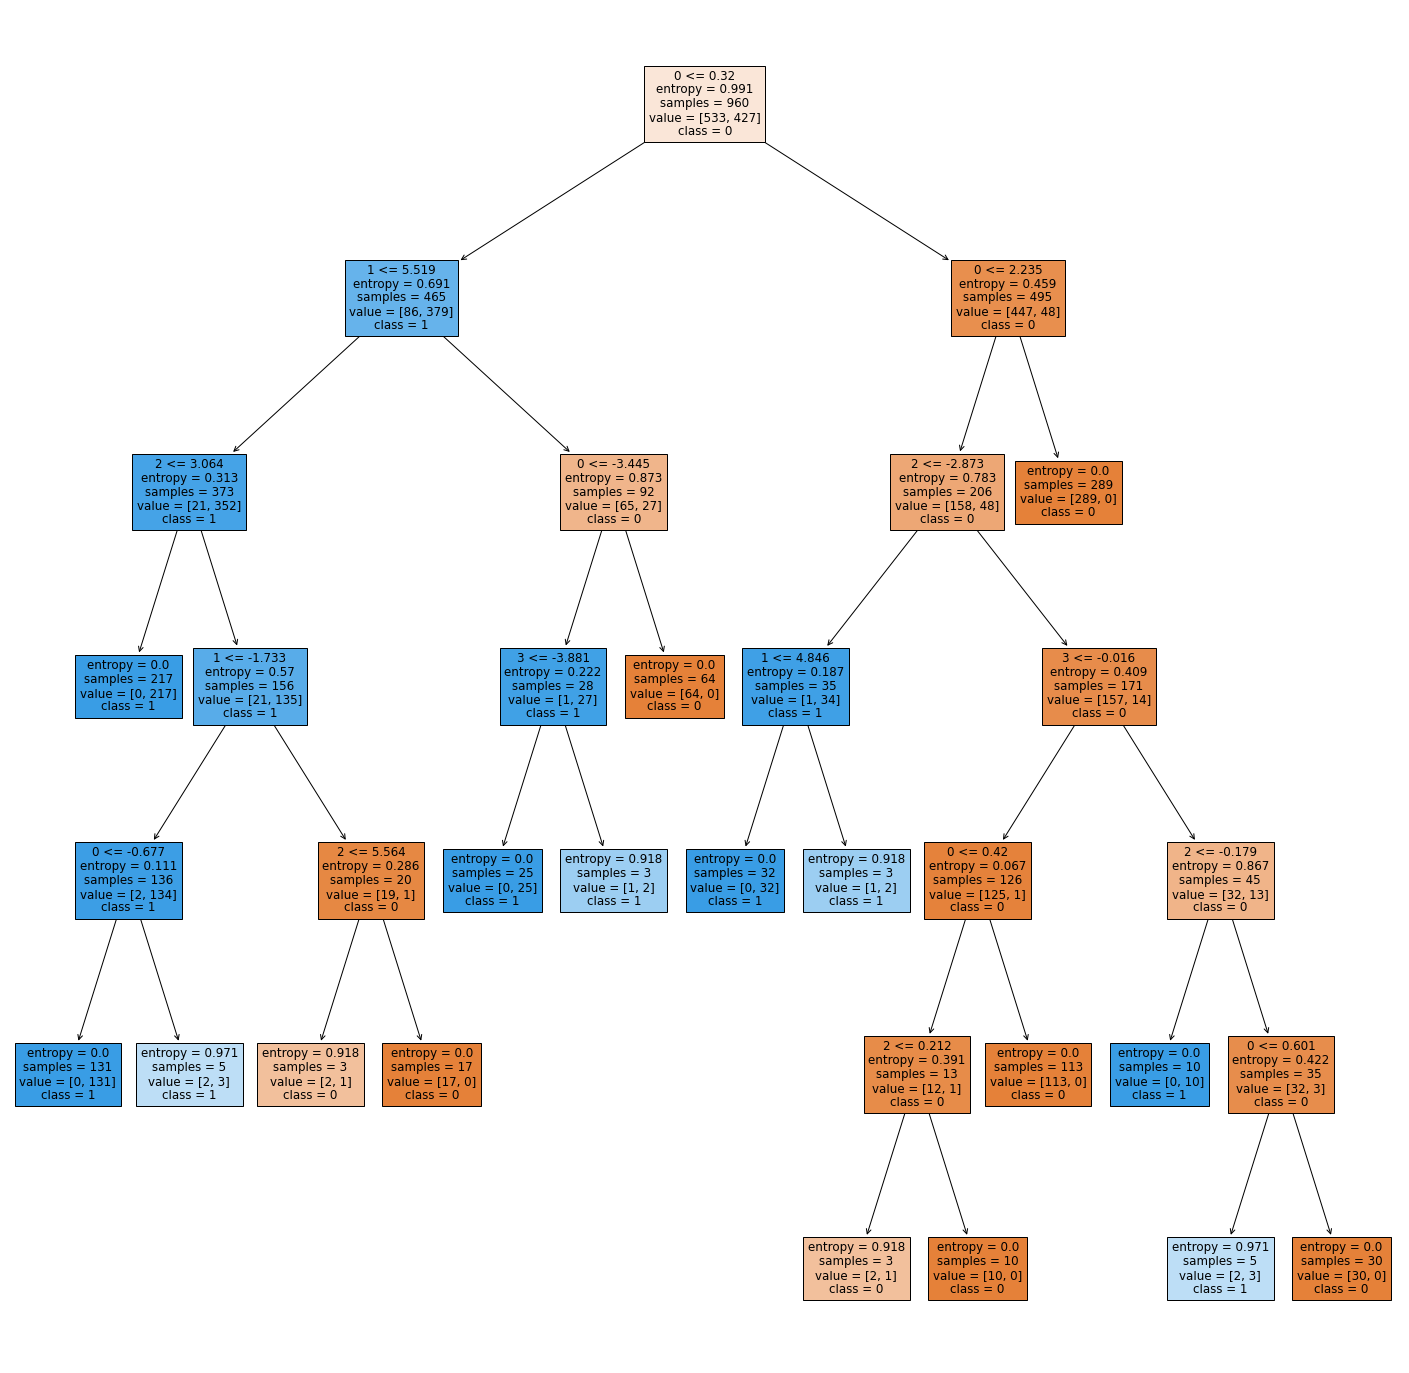

In [33]:
#create a visualization of the tree 
from sklearn import tree
import matplotlib.pyplot as plt

columns = [str(x) for x in features]

#This code differs from the video where it is using graphviz for visualizing the trees. Instead we will use plot_tree method
#from Sklean instead for it's simplicity.
fig = plt.figure(figsize=(25,25)) 
tree.plot_tree(dt,
                   feature_names=columns,  
                   class_names=columns,
                   filled=True)

## Question 6: Create a new text cell in your Notebook: Complete a 50-100 word summary (or short description of your thinking in applying this week's learning to the solution) of your experience in this assignment. Include: 
- What was your incoming experience with this model, if any? 
- what steps you took, what obstacles you encountered?
- how you link this exercise to real-world, machine learning problem-solving?
- What steps were missing? What else do you need to learn?

Decision trees are one of the most used Machine Learning Models in the aerospace industry (at least in my experience) as they provide a clear path to the prediction, or in other words this kind of model could be consider a white box.


In this project I was able to see the step-by-step process of a decision tree and the parameters that the model can use to determine if a node should or should not be split (gini index, information gain & entropy, among others). The main problem that I noticed for this project was to find a way to automize the splitting and selecting of leaves based on the best value provided by the specific information parameter, or even which information parameter is the best to use for a particular problem as the main lead to slightly different decision trees. 


Another thing that is clearly noticeable from this assignment is the downside of this model, which is the tendency to overfit the data since it could potentially a tree that classifies ever single value even if that means the creation of a leaf for every data point. For this reason it is very important to set constraints on the tree size or performing some sort of tree pruning at the end of the model.
